# TAL M2 Apprentissage artificiel - Projet final

Hongying XU, Simeng SONG, Xiaobo WANG

## Introduction

Dans ce projet, nous réalisons la **tâche 3 du défi DEFT 2009**. L'objectif est de créer un classifieur capable de deviner le parti politique d'un orateur en analysant son discours au Parlement européen.

Nous utilisons 3 architectures, dont : 

- baseline : Naive Bayes
- Linéaire : Logistique Régression 
- Deep Learning : LSTM

Nous allons construire les 3 modèles et finalement comparer la performance de ces 3 modèles avec la visualisation.

In [3]:
import os, glob
import numpy as np
import xml.etree.ElementTree as ET
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, f1_score, classification_report

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

/Users/elodie/TAL/M2/Apprentissage automatique et reseaux de neurones /Apprentissage_artificiel/venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Chargement des corpus

Dans cette section, nous chargons les différents fichiers de données :
- Corpus d'apprentissage : données XML pour l'entraînement du modèle
- Corpus de test : données XML pour l'évaluation
- Données de référence : fichiers texte contenant les labels (partis politiques)

Les données sont organisées en trois langues : anglais (en), français (fr) et italien (it).

In [4]:
DATA_DIR = os.path.expanduser("./deft09")

TRAIN_DIR = os.path.join(DATA_DIR, "Corpus d_apprentissage")
TEST_DIR  = os.path.join(DATA_DIR, "Corpus de test")
REF_DIR   = os.path.join(DATA_DIR, "Données de référence")

train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.xml")))
test_files  = sorted(glob.glob(os.path.join(TEST_DIR, "*.xml")))
ref_files   = sorted(glob.glob(os.path.join(REF_DIR, "*.txt")))

print("Train xml:", len(train_files), train_files)
print("Test  xml:", len(test_files), test_files[:3])
print("Ref   txt:", len(ref_files), ref_files[:3])

Train xml: 3 ['./deft09/Corpus d_apprentissage/deft09_parlement_appr_en.xml', './deft09/Corpus d_apprentissage/deft09_parlement_appr_fr.xml', './deft09/Corpus d_apprentissage/deft09_parlement_appr_it.xml']
Test  xml: 3 ['./deft09/Corpus de test/deft09_parlement_test_en.xml', './deft09/Corpus de test/deft09_parlement_test_fr.xml', './deft09/Corpus de test/deft09_parlement_test_it.xml']
Ref   txt: 3 ['./deft09/Données de référence/deft09_parlement_ref_en.txt', './deft09/Données de référence/deft09_parlement_ref_fr.txt', './deft09/Données de référence/deft09_parlement_ref_it.txt']


## Extraction des Labels comme Référence

On voudrait lire les fichiers de référence et crée un dictionnaire associant chaque document à son parti correspondant.

In [5]:
def get_id2label(ref_file_list):
    id2label = {}
    for fp in ref_file_list:
        with open(fp, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    # parts[0] = ID, parts[1] = parti
                    id2label[parts[0]] = parts[1]
    return id2label
    
id2label = get_id2label(ref_files)
print("Nb labels in reference:", len(id2label))
# voir exemples
print("Example:", list(id2label.items())[:5])

Nb labels in reference: 12917
Example: [('1', 'PPE-DE'), ('2', 'PPE-DE'), ('3', 'PPE-DE'), ('4', 'PPE-DE'), ('5', 'GUE-NGL')]


Et puis, cette fonction parcourt les fichiers XML et extrait les textes et les partis associé.
Par ailleurs, le texte est nettoyé en supprimant les espaces multiples et les caractères superflus.

In [6]:
def load_data_from_xml(xml_files, id2label_dict=None):
    texts = []
    labels = []
    
    for xml_path in xml_files:
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            for doc in root.findall(".//doc"):
                doc_id = doc.get("id")
                
                # extraction des textes
                texte_node = doc.find("texte")
                if texte_node is None: continue
                
                # nettoyer
                raw_text = "".join(texte_node.itertext())
                clean_text = re.sub(r"\s+", " ", raw_text).strip()
                if not clean_text: continue
                
                # extraction des labels
                label = None
                parti_node = doc.find(".//PARTI")
                if parti_node is not None:
                    label = parti_node.get("valeur")
                elif id2label_dict is not None:
                    # si il y a pas, chercher dans le dictionnaire de test
                    label = id2label_dict.get(doc_id)
                if label:
                    texts.append(clean_text)
                    labels.append(label)
                    
        except Exception as e:
            print(f"Erreur : {xml_path}: {e}")
            
    return texts, labels

In [7]:
id2label_dict = get_id2label(ref_files)

# chargement du set de train
train_texts, train_labels = load_data_from_xml(train_files)

# chargement du set de test
test_texts, test_labels = load_data_from_xml(test_files, id2label_dict)

print(f"Train Set : {len(train_texts)}")
print(f"Test Set : {len(test_texts)}")

Train Set : 58109
Test Set : 38743


Résultat est : 
- 58,109 textes d'entraînement
- 38,743 textes de test

## Encodage des Labels

On transforme les labels textuels en indices numériques, puis en vecteurs one-hot pour être utilisés par le réseau de neurones.

In [8]:
# label encoding
label_encoder = LabelEncoder()
y_train_idx = label_encoder.fit_transform(train_labels)
y_test_idx = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)
# one-hot encoding
y_train = to_categorical(y_train_idx, num_classes)
y_test = to_categorical(y_test_idx, num_classes)

In [9]:
# tokenization
MAX_VOCAB = 10000  # fixer le maximum de vocabulaire
MAX_LEN = 200      # garder 200 mots chaque phrase

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_test_seq = tokenizer.texts_to_sequences(test_texts)

# Padding
X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')
print("Labels des partis:", label_encoder.classes_)

Labels des partis: ['ELDR' 'GUE-NGL' 'PPE-DE' 'PSE' 'Verts-ALE']


## Modèle : Naive Bayes

**Approche** :
- Utilisation de TF-IDF pour la vectorisation des textes
- MultinomialNB pour la classification multi-classes


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

### Préparation des données pour Naive Bayes

Pour Naive Bayes, nous utilisons TF-IDF au lieu de la tokenization séquentielle utilisée pour LSTM. TF-IDF est mieux adapté aux modèles probabilistes basés sur les mots.


### Vectorisation TF-IDF

Pour Naive Bayes, nous utilisons TF-IDF (Term Frequency-Inverse Document Frequency) pour vectoriser les textes.


In [11]:
X_train_nb, X_val_nb, y_train_nb, y_val_nb = train_test_split(
    train_texts, 
    train_labels, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_labels
)

print(f"Train set: {len(X_train_nb)} échantillons")
print(f"Validation set: {len(X_val_nb)} échantillons")
print(f"Test set: {len(test_texts)} échantillons")


Train set: 46487 échantillons
Validation set: 11622 échantillons
Test set: 38743 échantillons


In [12]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  
    ngram_range=(1, 2),   
    min_df=2,            
    max_df=0.95,         
    lowercase=True,
    strip_accents='unicode'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_nb)
X_val_tfidf = tfidf_vectorizer.transform(X_val_nb)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

print(f"Shape des données TF-IDF - Train: {X_train_tfidf.shape}")
print(f"Shape des données TF-IDF - Validation: {X_val_tfidf.shape}")
print(f"Shape des données TF-IDF - Test: {X_test_tfidf.shape}")


Shape des données TF-IDF - Train: (46487, 10000)
Shape des données TF-IDF - Validation: (11622, 10000)
Shape des données TF-IDF - Test: (38743, 10000)


### Gestion du déséquilibre des classes

Les classes sont déséquilibrées (PPE-DE a beaucoup plus d'échantillons que ELDR). 
Nous allons utiliser des poids de classe pour améliorer les performances sur les classes minoritaires.


In [13]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_nb),
    y=y_train_nb
)

weight_dict = dict(zip(np.unique(y_train_nb), class_weights))
print("Poids des classes (pour gérer le déséquilibre):")
for cls, weight in sorted(weight_dict.items()):
    count = list(y_train_nb).count(cls)
    print(f"  {cls}: poids={weight:.3f}, échantillons={count}")

# Option 1: Probabilités uniformes
uniform_prior = np.ones(len(np.unique(y_train_nb))) / len(np.unique(y_train_nb))

# Option 2: Basé sur fréquence 
from collections import Counter
class_counts = Counter(y_train_nb)
total = sum(class_counts.values())
freq_prior = np.array([class_counts[cls] / total for cls in sorted(np.unique(y_train_nb))])

# Option 3: Lissé (mélange 70% uniforme + 30% fréquence)
smoothing_factor = 0.3
smoothed_prior = (1 - smoothing_factor) * uniform_prior + smoothing_factor * freq_prior
smoothed_prior = smoothed_prior / smoothed_prior.sum()

print("\n=== Options de class_prior ===")
print("\n1. Uniforme (toutes classes égales):")
for cls, prior in zip(sorted(np.unique(y_train_nb)), uniform_prior):
    print(f"   {cls}: {prior:.3f}")

print("\n2. Basé sur fréquence (par défaut):")
for cls, prior in zip(sorted(np.unique(y_train_nb)), freq_prior):
    print(f"   {cls}: {prior:.3f}")

print(f"\n3. Lissé (70% uniforme + 30% fréquence):")
for cls, prior in zip(sorted(np.unique(y_train_nb)), smoothed_prior):
    print(f"   {cls}: {prior:.3f}")


Poids des classes (pour gérer le déséquilibre):
  ELDR: poids=1.929, échantillons=4819
  GUE-NGL: poids=1.441, échantillons=6451
  PPE-DE: poids=0.565, échantillons=16458
  PSE: poids=0.712, échantillons=13056
  Verts-ALE: poids=1.630, échantillons=5703

=== Options de class_prior ===

1. Uniforme (toutes classes égales):
   ELDR: 0.200
   GUE-NGL: 0.200
   PPE-DE: 0.200
   PSE: 0.200
   Verts-ALE: 0.200

2. Basé sur fréquence (par défaut):
   ELDR: 0.104
   GUE-NGL: 0.139
   PPE-DE: 0.354
   PSE: 0.281
   Verts-ALE: 0.123

3. Lissé (70% uniforme + 30% fréquence):
   ELDR: 0.171
   GUE-NGL: 0.182
   PPE-DE: 0.246
   PSE: 0.224
   Verts-ALE: 0.177


### Entraînement des trois modèles avec différentes stratégies

Nous allons entraîner trois modèles Naive Bayes avec les trois stratégies de class_prior pour comparer leurs performances.


In [14]:
import matplotlib.pyplot as plt


In [15]:
# Entraînement de trois modèles avec différentes stratégies de class_prior
nb_models = {}
training_times = {}

strategies = {
    'uniforme': uniform_prior,
    'frequence': freq_prior,
    'lisse': smoothed_prior
}

print("=== Entraînement des trois modèles ===\n")

for strategy_name, class_prior in strategies.items():
    print(f" Modèle {strategy_name.upper()}:")
    print(f"   class_prior: {[f'{p:.3f}' for p in class_prior]}")
    
    model = MultinomialNB(alpha=1.0, class_prior=class_prior)
    
    start_time = time.time()
    model.fit(X_train_tfidf, y_train_nb)
    training_time = time.time() - start_time
    
    nb_models[strategy_name] = model
    training_times[strategy_name] = training_time
    
    print(f" Entraînement terminé en {training_time:.2f} secondes\n")


=== Entraînement des trois modèles ===

 Modèle UNIFORME:
   class_prior: ['0.200', '0.200', '0.200', '0.200', '0.200']
 Entraînement terminé en 0.07 secondes

 Modèle FREQUENCE:
   class_prior: ['0.104', '0.139', '0.354', '0.281', '0.123']
 Entraînement terminé en 0.04 secondes

 Modèle LISSE:
   class_prior: ['0.171', '0.182', '0.246', '0.224', '0.177']
 Entraînement terminé en 0.04 secondes



### Évaluation et comparaison des trois modèles


In [16]:
# Évaluation sur l'ensemble de validation
results_val = {}

print("=" * 70)
print("RÉSULTATS SUR L'ENSEMBLE DE VALIDATION")
print("=" * 70)

for strategy_name, model in nb_models.items():
    y_val_pred = model.predict(X_val_tfidf)
    
    accuracy = accuracy_score(y_val_nb, y_val_pred)
    f1_macro = f1_score(y_val_nb, y_val_pred, average='macro')
    f1_weighted = f1_score(y_val_nb, y_val_pred, average='weighted')
    
    results_val[strategy_name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': y_val_pred
    }
    
    print(f"\n Modèle {strategy_name.upper()}:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-score (macro): {f1_macro:.4f}")
    print(f"   F1-score (weighted): {f1_weighted:.4f}")

# Comparaison visuelle
print("\n" + "=" * 70)
print("COMPARAISON DES MÉTRIQUES")
print("=" * 70)

strategies_list = list(results_val.keys())
accuracies = [results_val[s]['accuracy'] for s in strategies_list]
f1_macros = [results_val[s]['f1_macro'] for s in strategies_list]
f1_weighteds = [results_val[s]['f1_weighted'] for s in strategies_list]

comparison_df = {
    'Stratégie': strategies_list,
    'Accuracy': [f'{a:.4f}' for a in accuracies],
    'F1-macro': [f'{f:.4f}' for f in f1_macros],
    'F1-weighted': [f'{f:.4f}' for f in f1_weighteds]
}

import pandas as pd
df_comparison = pd.DataFrame(comparison_df)
print("\n" + df_comparison.to_string(index=False))


RÉSULTATS SUR L'ENSEMBLE DE VALIDATION

 Modèle UNIFORME:
   Accuracy: 0.3949
   F1-score (macro): 0.3751
   F1-score (weighted): 0.3949

 Modèle FREQUENCE:
   Accuracy: 0.4134
   F1-score (macro): 0.2508
   F1-score (weighted): 0.3330

 Modèle LISSE:
   Accuracy: 0.4344
   F1-score (macro): 0.3515
   F1-score (weighted): 0.4043

COMPARAISON DES MÉTRIQUES

Stratégie Accuracy F1-macro F1-weighted
 uniforme   0.3949   0.3751      0.3949
frequence   0.4134   0.2508      0.3330
    lisse   0.4344   0.3515      0.4043


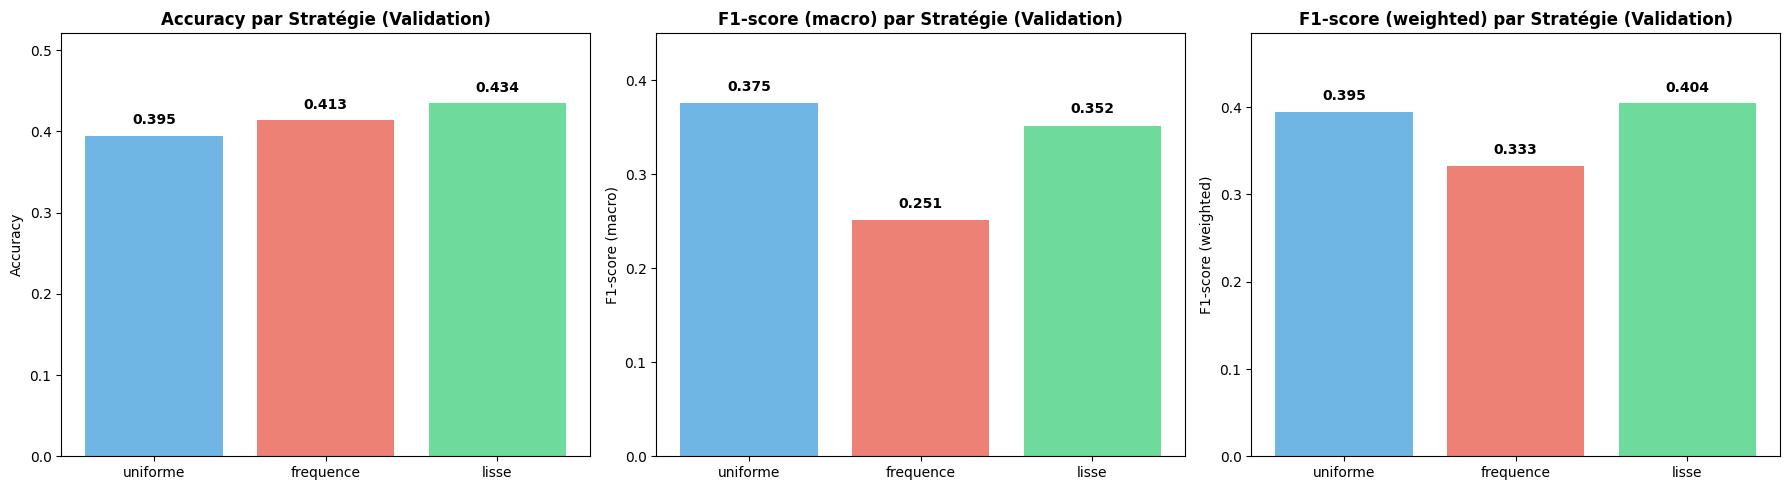

In [17]:
# Visualisation de la comparaison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].bar(strategies_list, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
axes[0].set_title('Accuracy par Stratégie (Validation)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, max(accuracies) * 1.2])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# F1-macro
axes[1].bar(strategies_list, f1_macros, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
axes[1].set_title('F1-score (macro) par Stratégie (Validation)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1-score (macro)')
axes[1].set_ylim([0, max(f1_macros) * 1.2])
for i, v in enumerate(f1_macros):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# F1-weighted
axes[2].bar(strategies_list, f1_weighteds, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
axes[2].set_title('F1-score (weighted) par Stratégie (Validation)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('F1-score (weighted)')
axes[2].set_ylim([0, max(f1_weighteds) * 1.2])
for i, v in enumerate(f1_weighteds):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### Classification Reports détaillés pour chaque stratégie


In [18]:
for strategy_name in strategies_list:
    print("=" * 70)
    print(f"CLASSIFICATION REPORT - Stratégie: {strategy_name.upper()}")
    print("=" * 70)
    print(classification_report(y_val_nb, results_val[strategy_name]['predictions'], 
                                target_names=label_encoder.classes_))
    print("\n")


CLASSIFICATION REPORT - Stratégie: UNIFORME
              precision    recall  f1-score   support

        ELDR       0.27      0.28      0.27      1205
     GUE-NGL       0.40      0.63      0.49      1613
      PPE-DE       0.52      0.39      0.44      4115
         PSE       0.40      0.36      0.38      3264
   Verts-ALE       0.26      0.33      0.29      1425

    accuracy                           0.39     11622
   macro avg       0.37      0.40      0.38     11622
weighted avg       0.41      0.39      0.39     11622



CLASSIFICATION REPORT - Stratégie: FREQUENCE
              precision    recall  f1-score   support

        ELDR       0.00      0.00      0.00      1205
     GUE-NGL       0.69      0.29      0.40      1613
      PPE-DE       0.39      0.87      0.54      4115
         PSE       0.40      0.24      0.30      3264
   Verts-ALE       0.78      0.00      0.01      1425

    accuracy                           0.41     11622
   macro avg       0.45      0.28      0

/Users/elodie/TAL/M2/Apprentissage automatique et reseaux de neurones /Apprentissage_artificiel/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/elodie/TAL/M2/Apprentissage automatique et reseaux de neurones /Apprentissage_artificiel/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/elodie/TAL/M2/Apprentissage automatique et reseaux de neurones /Apprentissage_artificiel/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: Undefin

### Évaluation sur l'ensemble de TEST


In [19]:
results_test = {}

print("=" * 70)
print("RÉSULTATS SUR L'ENSEMBLE DE TEST")
print("=" * 70)

for strategy_name, model in nb_models.items():
    y_test_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(test_labels, y_test_pred)
    f1_macro = f1_score(test_labels, y_test_pred, average='macro')
    f1_weighted = f1_score(test_labels, y_test_pred, average='weighted')
    
    results_test[strategy_name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': y_test_pred
    }
    
    print(f"\n Modèle {strategy_name.upper()}:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-score (macro): {f1_macro:.4f}")
    print(f"   F1-score (weighted): {f1_weighted:.4f}")

# Comparaison sur le test set
print("\n" + "=" * 70)
print("COMPARAISON DES MÉTRIQUES (TEST SET)")
print("=" * 70)

accuracies_test = [results_test[s]['accuracy'] for s in strategies_list]
f1_macros_test = [results_test[s]['f1_macro'] for s in strategies_list]
f1_weighteds_test = [results_test[s]['f1_weighted'] for s in strategies_list]

comparison_df_test = {
    'Stratégie': strategies_list,
    'Accuracy': [f'{a:.4f}' for a in accuracies_test],
    'F1-macro': [f'{f:.4f}' for f in f1_macros_test],
    'F1-weighted': [f'{f:.4f}' for f in f1_weighteds_test]
}

df_comparison_test = pd.DataFrame(comparison_df_test)
print("\n" + df_comparison_test.to_string(index=False))


RÉSULTATS SUR L'ENSEMBLE DE TEST

 Modèle UNIFORME:
   Accuracy: 0.2900
   F1-score (macro): 0.2627
   F1-score (weighted): 0.2957

 Modèle FREQUENCE:
   Accuracy: 0.3532
   F1-score (macro): 0.1855
   F1-score (weighted): 0.2698

 Modèle LISSE:
   Accuracy: 0.3337
   F1-score (macro): 0.2407
   F1-score (weighted): 0.3052

COMPARAISON DES MÉTRIQUES (TEST SET)

Stratégie Accuracy F1-macro F1-weighted
 uniforme   0.2900   0.2627      0.2957
frequence   0.3532   0.1855      0.2698
    lisse   0.3337   0.2407      0.3052


### Matrices de confusion pour les trois stratégies


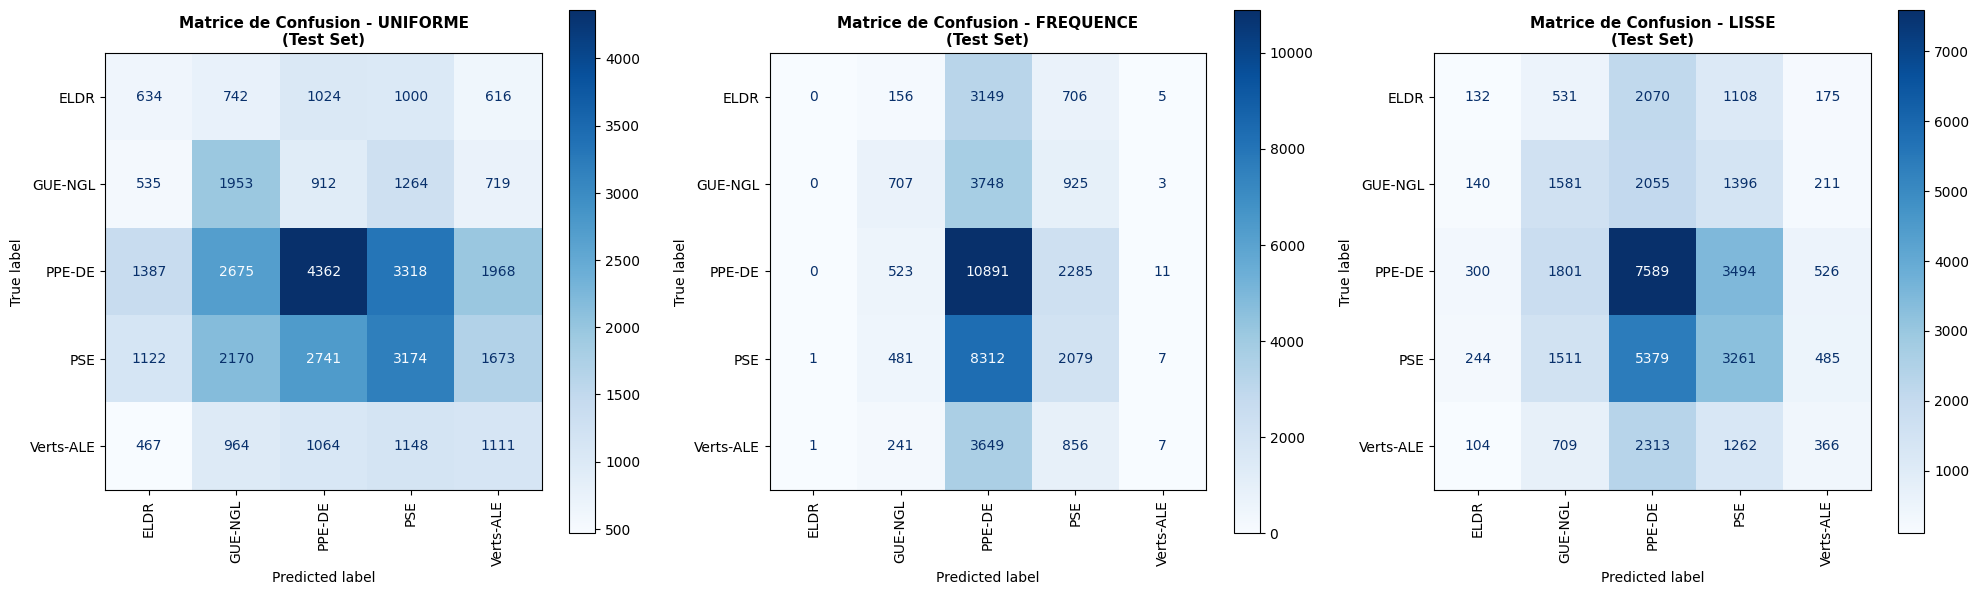

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, strategy_name in enumerate(strategies_list):
    cm = confusion_matrix(test_labels, results_test[strategy_name]['predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
    axes[idx].set_title(f'Matrice de Confusion - {strategy_name.upper()}\n(Test Set)', 
                        fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


### Analyse des performances par classe pour chaque stratégie


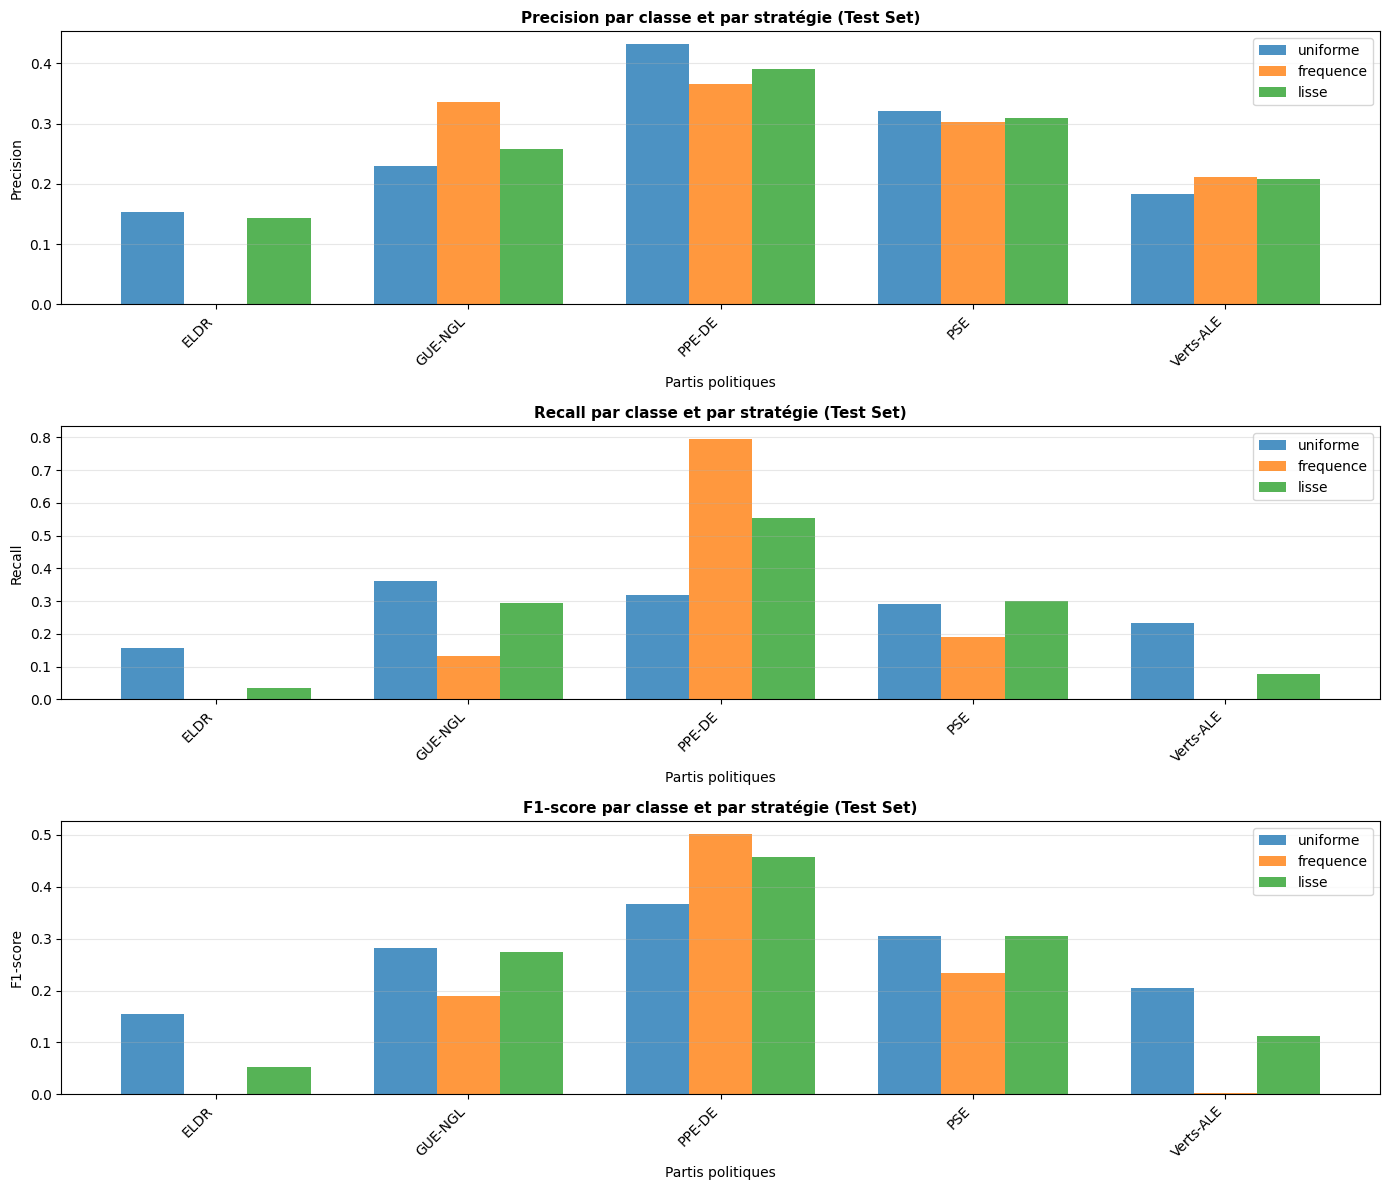

In [21]:
# Extraction des métriques par classe pour chaque stratégie
classes = label_encoder.classes_
metrics_by_strategy = {}

for strategy_name in strategies_list:
    report = classification_report(test_labels, results_test[strategy_name]['predictions'],
                                   target_names=classes, output_dict=True)
    
    precision = [report[cls]['precision'] for cls in classes]
    recall = [report[cls]['recall'] for cls in classes]
    f1 = [report[cls]['f1-score'] for cls in classes]
    
    metrics_by_strategy[strategy_name] = {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Visualisation
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

metric_names = ['precision', 'recall', 'f1']
metric_labels = ['Precision', 'Recall', 'F1-score']

for metric_idx, (metric_name, metric_label) in enumerate(zip(metric_names, metric_labels)):
    x = np.arange(len(classes))
    width = 0.25
    
    for i, strategy_name in enumerate(strategies_list):
        offset = (i - 1) * width
        axes[metric_idx].bar(x + offset, metrics_by_strategy[strategy_name][metric_name], 
                            width, label=strategy_name, alpha=0.8)
    
    axes[metric_idx].set_xlabel('Partis politiques')
    axes[metric_idx].set_ylabel(metric_label)
    axes[metric_idx].set_title(f'{metric_label} par classe et par stratégie (Test Set)', 
                               fontsize=11, fontweight='bold')
    axes[metric_idx].set_xticks(x)
    axes[metric_idx].set_xticklabels(classes, rotation=45, ha='right')
    axes[metric_idx].legend()
    axes[metric_idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Résumé et conclusion


In [22]:
# Sauvegarde des résultats pour comparaison ultérieure avec LSTM et Régression Logistique
nb_results_all = {}

for strategy_name in strategies_list:
    nb_results_all[strategy_name] = {
        'model': f'Naive Bayes ({strategy_name})',
        'validation': {
            'accuracy': results_val[strategy_name]['accuracy'],
            'f1_macro': results_val[strategy_name]['f1_macro'],
            'f1_weighted': results_val[strategy_name]['f1_weighted']
        },
        'test': {
            'accuracy': results_test[strategy_name]['accuracy'],
            'f1_macro': results_test[strategy_name]['f1_macro'],
            'f1_weighted': results_test[strategy_name]['f1_weighted']
        },
        'training_time': training_times[strategy_name]
    }

print("=" * 70)
print("RÉSUMÉ FINAL - NAIVE BAYES")
print("=" * 70)

for strategy_name in strategies_list:
    print(f"\nStratégie: {strategy_name.upper()}")
    print(f"   Temps d'entraînement: {training_times[strategy_name]:.2f} secondes")
    print(f"   Validation - Accuracy: {results_val[strategy_name]['accuracy']:.4f}, "
          f"F1-macro: {results_val[strategy_name]['f1_macro']:.4f}")
    print(f"   Test - Accuracy: {results_test[strategy_name]['accuracy']:.4f}, "
          f"F1-macro: {results_test[strategy_name]['f1_macro']:.4f}")

# Identifier la meilleure stratégie
best_strategy_val = max(strategies_list, key=lambda s: results_val[s]['f1_macro'])
best_strategy_test = max(strategies_list, key=lambda s: results_test[s]['f1_macro'])

print(f"\n Meilleure stratégie (validation, F1-macro): {best_strategy_val.upper()}")
print(f"Meilleure stratégie (test, F1-macro): {best_strategy_test.upper()}")

# Sauvegarder le meilleur modèle pour comparaison avec autres modèles
best_model_nb = nb_models[best_strategy_test]
nb_results = nb_results_all[best_strategy_test].copy()


RÉSUMÉ FINAL - NAIVE BAYES

Stratégie: UNIFORME
   Temps d'entraînement: 0.07 secondes
   Validation - Accuracy: 0.3949, F1-macro: 0.3751
   Test - Accuracy: 0.2900, F1-macro: 0.2627

Stratégie: FREQUENCE
   Temps d'entraînement: 0.04 secondes
   Validation - Accuracy: 0.4134, F1-macro: 0.2508
   Test - Accuracy: 0.3532, F1-macro: 0.1855

Stratégie: LISSE
   Temps d'entraînement: 0.04 secondes
   Validation - Accuracy: 0.4344, F1-macro: 0.3515
   Test - Accuracy: 0.3337, F1-macro: 0.2407

 Meilleure stratégie (validation, F1-macro): UNIFORME
Meilleure stratégie (test, F1-macro): UNIFORME


## Modèle : LSTM

### 3 Coches principales : 

1. Couche Embedding (100 dimensions)

2. Couche LSTM (64 unités)

3. Couche Dense (softmax)

In [16]:
# création du modèle
model = models.Sequential([
    layers.Embedding(input_dim=MAX_VOCAB, output_dim=100, input_length=MAX_LEN),
    
    layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', # classification multi-classe
              metrics=['accuracy'])

/home/sibel/mlenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-12-28 15:31:32.144987: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
# entraînement du modèle
history = model.fit(X_train, y_train,
                    epochs=10, # j'ai augmenté les epochs car l'accuracy n'est pas très bien
                    batch_size=32,
                    validation_data=(X_test, y_test)) 

Epoch 1/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 176s 95ms/step - accuracy: 0.3540 - loss: 1.4886 - val_accuracy: 0.3528 - val_loss: 1.4916
Epoch 2/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 96ms/step - accuracy: 0.3846 - loss: 1.4320 - val_accuracy: 0.3479 - val_loss: 1.5104
Epoch 3/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.4474 - loss: 1.3137 - val_accuracy: 0.3539 - val_loss: 1.5862
Epoch 4/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.5181 - loss: 1.1690 - val_accuracy: 0.3570 - val_loss: 1.7070
Epoch 5/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.5739 - loss: 1.0422 - val_accuracy: 0.3571 - val_loss: 1.8409
Epoch 6/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.6265 - loss: 0.9289 - val_accuracy: 0.3568 - val_loss: 1.9839
Epoch 7/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 173s 95ms/step - accuracy: 0.6714 - loss: 0.8261 - val_accuracy: 0.3571 - val_loss: 2.2131
Epoch 8/10
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 174s 96ms/step - accuracy: 

In [18]:
# évaluation sur test set
y_pred = model.predict(X_test)
y_pred_ids = np.argmax(y_pred, axis=1)

print(classification_report(y_test_idx, y_pred_ids, target_names=label_encoder.classes_))

1211/1211 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step
              precision    recall  f1-score   support

        ELDR       0.24      0.24      0.24      4016
     GUE-NGL       0.35      0.31      0.33      5383
      PPE-DE       0.44      0.46      0.45     13710
         PSE       0.37      0.40      0.38     10880
   Verts-ALE       0.27      0.21      0.24      4754

    accuracy                           0.37     38743
   macro avg       0.33      0.33      0.33     38743
weighted avg       0.37      0.37      0.37     38743



## Visualisation

In [19]:
import matplotlib.pyplot as plt

### Learning Curves

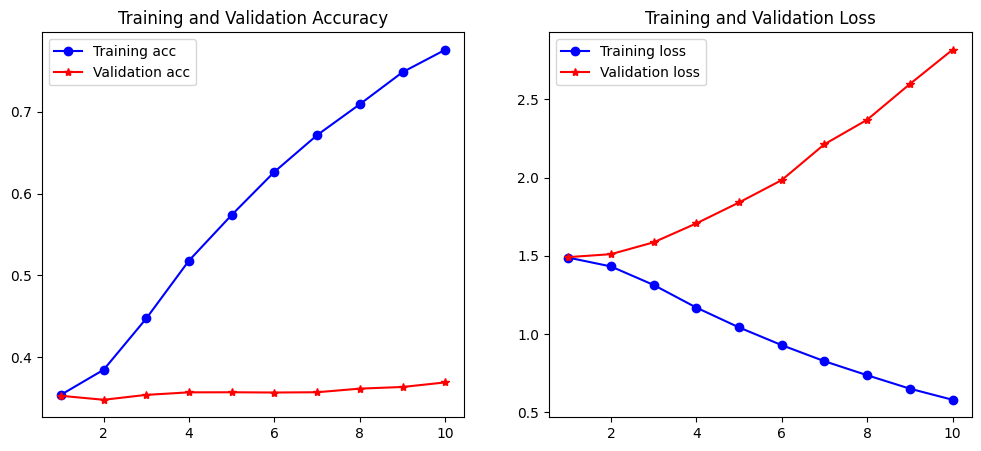

In [20]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'r*-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()
    
plot_history(history)

### Confusion Matrix

<Figure size 2000x2000 with 0 Axes>

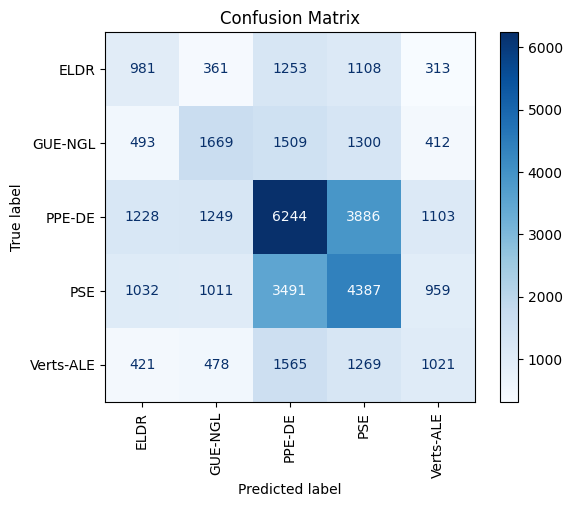

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_idx, y_pred_ids)

plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')

plt.title("Confusion Matrix")
plt.show()